### Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn import metrics
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import tensorflow as tf
import time
import shap
import lime
from lime import lime_tabular

### Data Preprocessing

In [4]:
file_path = "C:/Users/Dell/Downloads/SY_NG/Myfile_dataA_5000.csv"
csvFile = pd.read_csv(file_path)

In [5]:
csvFile.shape

(5000, 9)

In [9]:
csvFile = csvFile.dropna()

In [11]:
csvFile.isna().sum()

Gate_Length          0
Work_function        0
Channel_Thickness    0
Oxide_Thickness      0
SD_doping            0
SUBSTRATE_doping     0
Gate_Voltage         0
Drain_Voltage        0
Drain Current        0
dtype: int64

In [13]:
csvFile.head()

,Gate_Length,Work_function,Channel_Thickness,Oxide_Thickness,SD_doping,SUBSTRATE_doping,Gate_Voltage,Drain_Voltage,Drain Current
0,1.220000e-08,4.606941,1.090000e-08,1.350000e-09,3.700000e+20,1.130000e+17,0.078664,0.216504,2.070000e-12
1,1.900000e-08,4.492014,1.090000e-08,1.360000e-09,4.060000e+20,2.210000e+17,0.496761,0.591274,2.120000e-12
2,1.080000e-08,4.331288,1.020000e-08,1.090000e-09,6.650000e+20,2.660000e+17,0.185672,0.798587,2.160000e-12
3,1.340000e-08,4.081299,1.010000e-08,1.200000e-09,4.820000e+20,2.490000e+17,0.166393,0.878277,2.210000e-12
4,1.440000e-08,4.254729,1.080000e-08,1.780000e-09,6.530000e+20,2.630000e+17,0.764250,0.111511,2.260000e-12


In [15]:
num_features = ["Gate_Length", "Work_function", "Channel_Thickness", "Oxide_Thickness", "SD_doping", 
                "SUBSTRATE_doping", "Gate_Voltage", "Drain_Voltage"]
X = csvFile[num_features]
y = csvFile["Drain Current"]

In [17]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

### Data Splitting (80% Training Data and 20% Testing Data)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4000, 8) (4000,)
(1000, 8) (1000,)


### Model: Kernel Ridge Regressor

In [21]:
param_grid = {
    'alpha': np.logspace(-2, 1, 7),  # Increased regularization strength
    'kernel': ['linear', 'rbf', 'polynomial'],  # Simpler kernels
    'degree': [2],  # Lower polynomial degree
    'gamma': np.logspace(-1, 0.15, 5),  # Reduced gamma range
    'coef0': [0, 1]  # Limited coef0 values
}

In [22]:
krr = KernelRidge()
random_search = RandomizedSearchCV(krr, param_distributions=param_grid, n_iter=100, 
                                  cv=5, scoring='r2', n_jobs=-1, random_state=42)
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=KernelRidge(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': array([ 0.01      ,  0.03162278,  0.1       ,  0.31622777,  1.        ,
        3.16227766, 10.        ]),
                                        'coef0': [0, 1], 'degree': [2],
                                        'gamma': array([0.1       , 0.19386526, 0.3758374 , 0.72861817, 1.41253754]),
                                        'kernel': ['linear', 'rbf',
                                                   'polynomial']},
                   random_state=42, scoring='r2')

In [23]:
best_krr = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'kernel': 'rbf', 'gamma': 1.4125375446227544, 'degree': 2, 'coef0': 1, 'alpha': 0.01}


In [24]:
y_pred = best_krr.predict(x_test)
print('\nMean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
r2_score = metrics.r2_score(y_test, y_pred)
print('R² Score:', r2_score)


Mean Absolute Error: 3.6282395184833426e-08
Mean squared Error: 2.37214192956449e-15
Root Mean Squared Error: 4.8704639712911235e-08
R² Score: 0.9822012546531815


### Overfitting Analysis - Learning Curve and Cross-Validation

In [26]:
train_sizes, train_scores, test_scores = learning_curve(best_krr, X_scaled, y, cv=5, scoring='r2',
                                                        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1)

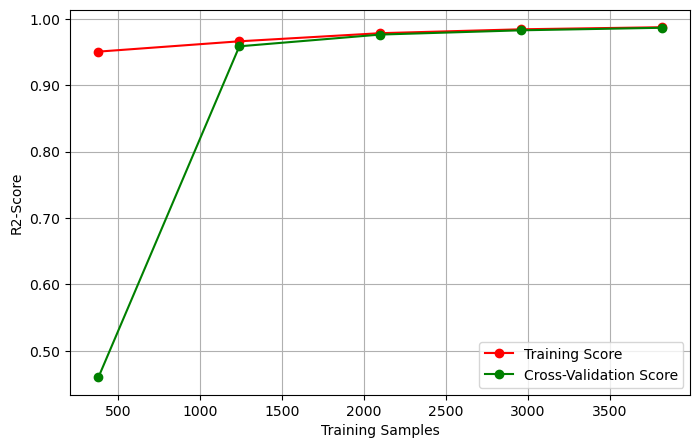

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Cross-Validation Score')
plt.xlabel('Training Samples')
plt.ylabel('R2-Score')
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
plt.legend()
plt.grid()
plt.show()

### Model Inference Time

In [29]:
num_inferences = 10
X_test_tensor = tf.convert_to_tensor(x_test)

start_time = time.time()

for _ in range(num_inferences):
    predictions = best_krr.predict(X_test_tensor)

end_time = time.time()

average_inference_time = (end_time - start_time) / num_inferences
print(f"Average inference time for ML model: {average_inference_time:.6f} seconds")

Average inference time for ML model: 0.058392 seconds


### SHAP

In [42]:
explainer = shap.Explainer(best_krr.predict, x_train)

In [43]:
shap_values = explainer(x_test)

ExactExplainer explainer: 956it [20:45,  1.31s/it]                         


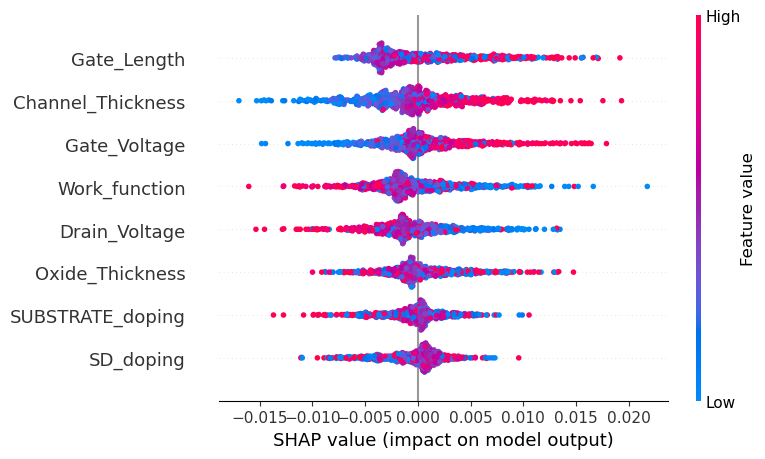

In [21]:
# Summary plot of feature importance
shap.summary_plot(shap_values, x_test, show = False)
# plt.savefig("KRR_shap_summary_plot.png", dpi=300, bbox_inches='tight')

In [22]:
shap_values.shape

(750, 8)

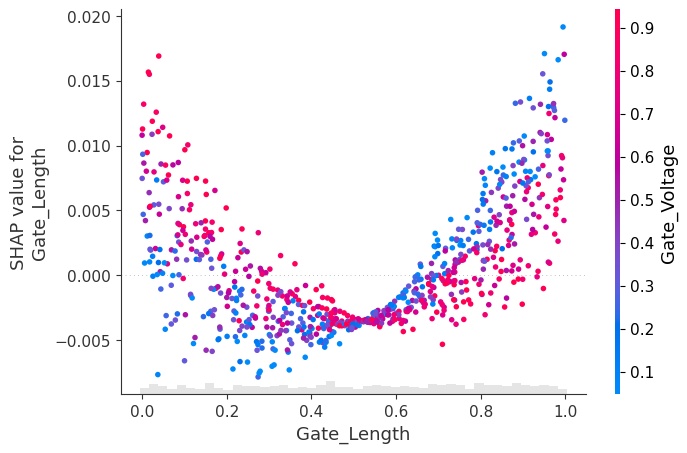

In [23]:
shap.plots.scatter(shap_values[:, 0], color = shap_values, show=False)
plt.savefig("KRR_shap_scatter_plot_1.png", dpi=300, bbox_inches='tight')
# shap_values[:,:]

In [26]:
shap.plots.waterfall(shap_values[749], show=False)
plt.savefig("KRR_shap_waterfall_plot.png", dpi=300, bbox_inches='tight')

In [27]:
shap.plots.beeswarm(shap_values, show=False)
plt.savefig("KRR_shap_beeswarm_plot.png", dpi=300, bbox_inches='tight')

### LIME

In [46]:
lime_explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(x_train), feature_names=x_train.columns, mode='regression')

In [48]:
explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=x_train.columns.values.tolist(), class_names=['MEDV'], 
                                                   verbose=True, mode='regression')

In [50]:
j = 5
exp = explainer.explain_instance(x_test.values[j], krr.predict, num_features=6)

Intercept 0.09462698455216721
Prediction_local [0.10620547]
Right: 0.0850912832091879


In [52]:
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
fig.savefig("KRR_lime_explanation_plot_1.png", dpi=300, bbox_inches='tight')

In [54]:
exp.as_list()

[('Gate_Voltage > 0.75', 0.005514506882716074),
 ('Gate_Length > 0.74', 0.005494898465059523),
 ('Work_function <= 0.25', 0.0044306953090060145),
 ('0.25 < Channel_Thickness <= 0.50', -0.004013616499821218),
 ('0.51 < SD_doping <= 0.76', 0.0024438007851788446),
 ('0.51 < Drain_Voltage <= 0.76', -0.002291798297035827)]

In [56]:
j = 5
exp = explainer.explain_instance(x_test.values[j], krr.predict, num_features=6)

Intercept 0.09499367387886186
Prediction_local [0.10501715]
Right: 0.0850912832091879


In [58]:
exp.show_in_notebook(show_table=True)
fig = exp.as_pyplot_figure()
fig.savefig("KRR_lime_explanation_plot_2.png", dpi=300, bbox_inches='tight')

In [60]:
exp.as_list()

[('Gate_Length > 0.74', 0.006495075190439017),
 ('Gate_Voltage > 0.75', 0.006320118471736775),
 ('Work_function <= 0.25', 0.00472694682598861),
 ('0.25 < Channel_Thickness <= 0.50', -0.0036137170467373547),
 ('0.51 < Drain_Voltage <= 0.76', -0.0022217791462767612),
 ('SUBSTRATE_doping > 0.74', -0.001683166671205394)]

### How Kernel Ridge Regressor Model Influences eXplainable AI (XAI)

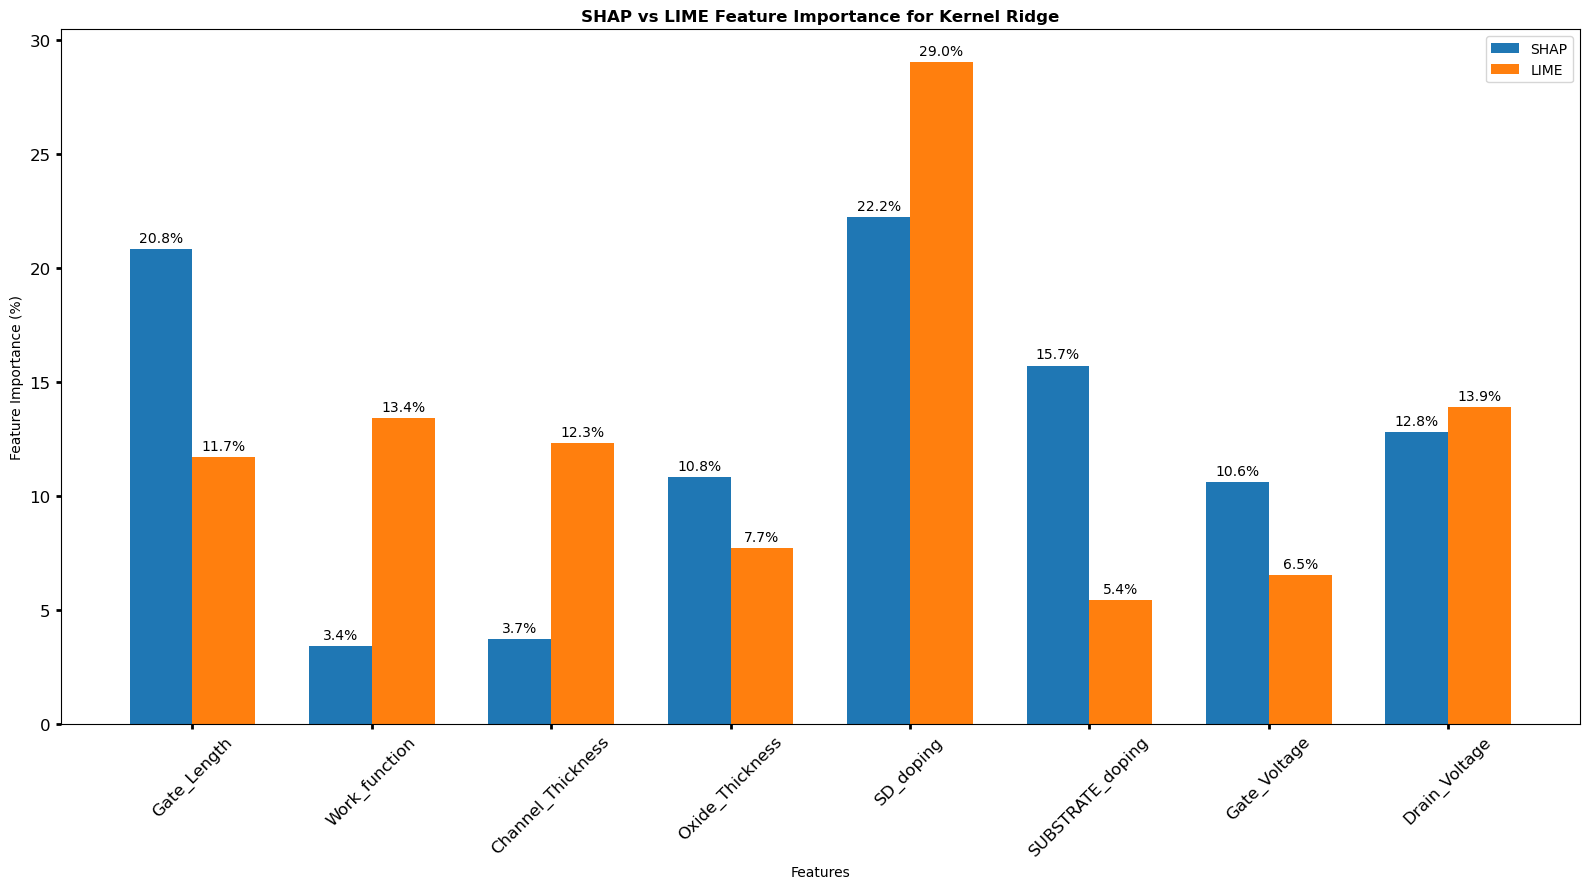

In [61]:
features = ['Gate_Length', 'Work_function', 'Channel_Thickness', 'Oxide_Thickness',
            'SD_doping', 'SUBSTRATE_doping', 'Gate_Voltage', 'Drain_Voltage']

shap_values = {
     'Kernel Ridge': [20.8, 3.4, 3.7, 10.8, 22.2, 15.7, 10.6, 12.8],
}

lime_values = {
       'Kernel Ridge': [11.7, 13.4, 12.3, 7.7, 29.0, 5.4, 6.5, 13.9], 
}

def plot_feature_importance(shap_values, lime_values, model_name):
    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 9))
    
    rects1 = ax.bar(x - width/2, shap_values, width, label='SHAP')
    rects2 = ax.bar(x + width/2, lime_values, width, label='LIME')

    ax.set_xlabel('Features')
    ax.set_ylabel('Feature Importance (%)')
    ax.set_title(f'SHAP vs LIME Feature Importance for {model_name}', fontweight='bold')
    
    ax.set_xticks(x)
    ax.set_xticklabels(features, rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=12, width=2)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

for model_name in shap_values.keys():
    plot_feature_importance(shap_values[model_name], lime_values[model_name], model_name)